## generate adversary image 
This code is trying to generate adversary images based on MNIST classifier of [Deep MNIST for Experts](https://www.tensorflow.org/get_started/mnist/pros)

### Preparation
import neccesary libraries, load MNIST dataset, and define some variables and constant values.

In [1]:
#import libraries
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import math
import pickle
%matplotlib inline

In [2]:
#load mnist dataset
mnist_data = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


MNIST dataset is consists of the image with size of 28x28, so each image would be 28x28 = 784 dimention vector after reshape. Each image's label falls under any of 0 to 9, so total number of classies is 10.

In [3]:
#define number of classes and data size of each image
NUM_CLASSES = 10
IMAGE_SIZE_1D = 784  #28 * 28

define placeholders to put the input images and labels later

In [4]:
#define placeholders
x_data = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE_1D])
y_label = tf.placeholder(tf.float32, shape=[None, NUM_CLASSES])

### linear regression model (TensorFlow Tutorial  #1)

I try to train linear regression model and use it to generate adversary images of digit two.
Due to its linearity, the model should misclassify generated adverary image based on the added feature value.
For example, if I add feature value of digit six to the image of digit two, the model should predict the noise added images as digit six.  
since logit is given by the following formula:  
$$ y = W^T X + b$$
gradint of loss respect to X would be W, which is weight parameter

let's define hyper parameter values and target classes which the image will be changed from and to. 

In [5]:
#define high-parameter values
num_epoch = 1000
batch_siz_linear = 100
epsilon = 0.25
dst_target = 6     #the class which images will be changed to
org_target = 2     #the class which images will be chnaged from

train the linear regression model, and also generate the adversary images

In [6]:
#linear regression model
def linear_model(epochs, batch_size,epsilon,adversary_dst_target,adversary_org_target):
    #follow TensorFlow turtorial
    #linear regression model
    
    #declare variables for weight parameter
    W = tf.Variable(tf.zeros([IMAGE_SIZE_1D,NUM_CLASSES]))
    b = tf.Variable(tf.zeros([NUM_CLASSES]))
    
     #setup loss function, gradient step, prediction, accuravy etc. 
    pred = tf.matmul(x_data,W) + b
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=pred))
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(y_label,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    #set flags to pick up images of digit two
    isDigitTwo = tf.equal(tf.argmax(pred,1), adversary_org_target)
    isCorrectTwo = tf.cast(tf.cast(correct_prediction,tf.float32) * tf.cast(isDigitTwo, tf.float32),tf.bool)
    isCorrectTwo_index = tf.where(isCorrectTwo)
    
    #onehot code of class 2
    class_two = [adversary_org_target]
    onehot_two = np.eye(NUM_CLASSES)[class_two]
    onehot_two_mult = np.zeros((10,NUM_CLASSES))  #prepare it for all 10 samples
    for j in range(10):
        onehot_two_mult[j] = onehot_two
    
    #np array to store generated imgs and extracted imgs
    generated_imgs = np.zeros((NUM_CLASSES,IMAGE_SIZE_1D))
    extracted_two_imgs = np.zeros((NUM_CLASSES,IMAGE_SIZE_1D))
    
    with tf.Session() as sess:
        #initialize variables
        sess.run(tf.global_variables_initializer())

        #train the model
        for _ in range(epochs):
            batch = mnist_data.train.next_batch(batch_size)
            train_step.run(feed_dict={x_data: batch[0], y_label: batch[1]})

        #evaluate the model by accuracy
        print("Accuracy is:", accuracy.eval(feed_dict={x_data: mnist_data.test.images, y_label: mnist_data.test.labels}))
        
        #extract 10 samples of digit two images
        predition_correct_two = sess.run(isCorrectTwo_index, feed_dict={x_data:mnist_data.test.images,y_label: mnist_data.test.labels})
        predition_correct_two_index = [item for sublist in predition_correct_two.tolist() for item in sublist]
        for j in range(10):
            extracted_two_imgs[j] = mnist_data.test.images[predition_correct_two_index[j]]
        
        ### generate adversary images ###
        # gradient = gradient of WX + b respect to X -> gradient =  W
        # noise = epsilon * sign(gradient)
        W_var = sess.run(W)
        noise_six = epsilon * np.sign(W_var[:,adversary_dst_target])
        
        #add weight value to each original image
        for i in range(10):
            generated_imgs[i] = noise_six + extracted_two_imgs[i] 
            pred_w = sess.run(pred,feed_dict={x_data:np.reshape(generated_imgs[i],(1,IMAGE_SIZE_1D))})
            pred_w_index = np.argmax(pred_w)
            print ('prediction: %d' %pred_w_index)
            
        #calculate error rate on adversary images
        print("error rate is:", (1-accuracy.eval(feed_dict={x_data: generated_imgs, y_label: onehot_two_mult})))
        
        return generated_imgs,extracted_two_imgs;
        

In [7]:
#run the model
gen_imgs,org_imgs = linear_model(num_epoch,batch_siz_linear,epsilon,dst_target,org_target)

Accuracy is: 0.9144
prediction: 6
prediction: 6
prediction: 6
prediction: 6
prediction: 6
prediction: 6
prediction: 6
prediction: 6
prediction: 6
prediction: 6
error rate is: 1.0


visualize generated adversary images and added noise(weight for target class)

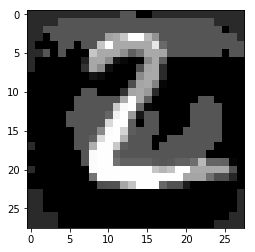

In [8]:
#visualize generated img
plt.imshow(np.reshape(gen_imgs[0],(28,28)), cmap='gray')

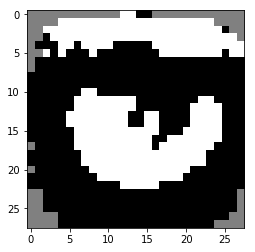

In [9]:
#visualize added weight
weight_added = gen_imgs - org_imgs
plt.imshow(np.reshape(weight_added[0],(28,28)),cmap='gray')

also compare the differnece among original images, delta(weight) and adversary images

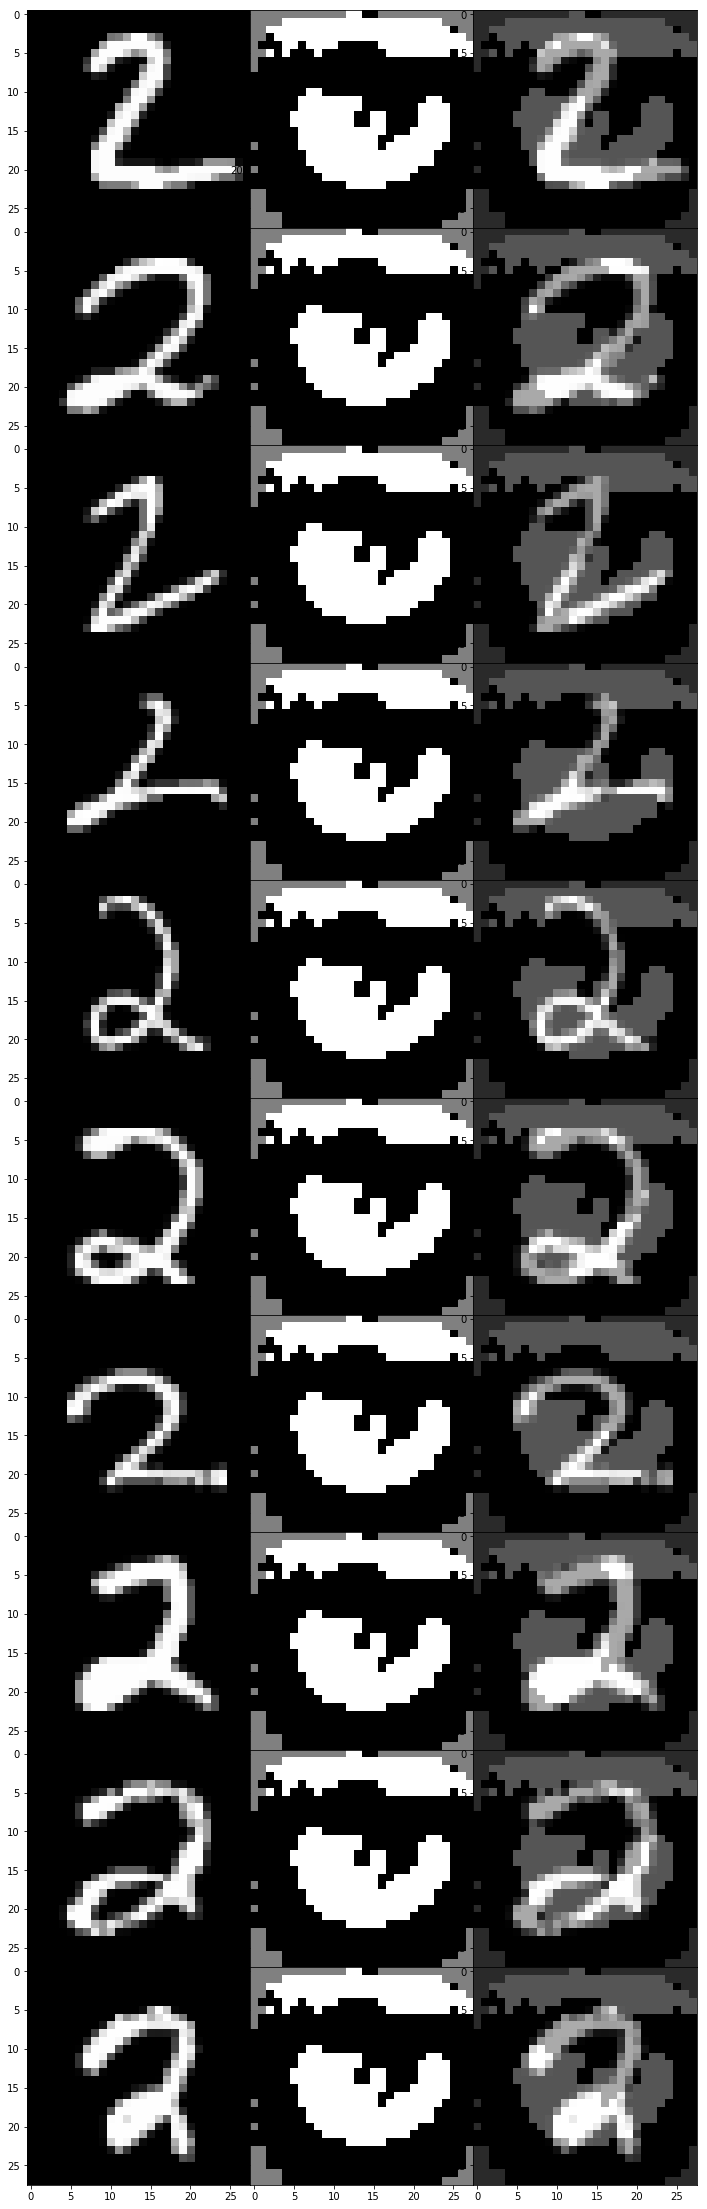

In [10]:
#visualize the original picture,delta and generated images
fig_linear = plt.figure(figsize=(12,40))
grid = gridspec.GridSpec(10, 3,wspace=0.0,hspace=0.0)

for i in range(10):
    #original images
    ax1 = plt.subplot(grid[i*3])
    ax1.imshow(np.reshape(org_imgs[i],(28,28)),cmap='gray',interpolation='nearest', aspect='auto')
    fig_linear.add_subplot(ax1)
    
    #delta images
    ax2 = plt.subplot(grid[i*3+1])
    ax2.imshow(np.reshape(weight_added[i],(28,28)),cmap='gray',interpolation='nearest', aspect='auto')
    fig_linear.add_subplot(ax2)
    
    #generated images  
    ax3 = plt.subplot(grid[i*3+2]) 
    ax3.imshow(np.reshape(gen_imgs[i],(28,28)),cmap='gray',interpolation='nearest', aspect='auto')
    fig_linear.add_subplot(ax3)

plt.subplots_adjust(left=None,top=None,bottom=None,right=None,wspace=0,hspace=0)
    
plt.show()
fig_linear.savefig('./MNIST_generated/gen_linear_model.png',bbox_inches='tight')
fig_linear.clf()

### ConvNet model (TensorFlow Tutorial #2) 

I train the ConvNet model of MNIST classifier and use it to generate adversary images of digit two. First, I define the structure of the model globally and update the parameter values through calling function named convnet_model_train. I retieve the updated weight values to generate adversary images later.

let's define hyper parameters first

In [11]:
#define hyper parametres
num_epochs_conv = 20000 
batch_siz = 50
epsilon = 0.25
epochs_adversary = 150     #set how many times to update input images when I generate adversary images
learning_rate_adversary = 0.2 

define function used to declare variables

In [12]:
#functions to declare variables
def weight_variable(shape,name_):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,name=name_)

def bias_variable(shape,name_):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial,name=name_)

#functions to define conv layer and pooling layes
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

#function to declare variable for input images
def input_img_variable(batch_size):
    return tf.Variable(tf.zeros([batch_size,28,28,1]),trainable=False)

Since I need to update input images to generate adverary images, I declare input images as variable instead of placeholder.

In [13]:
#define how to feed input images to convnet as input
#reshape placeholder of input data
x_image = tf.reshape(x_data, [-1, 28, 28, 1])

#declare variable for img input
x_img_var = input_img_variable(batch_siz)

#assign operation for x_image
assign_x = tf.assign(x_img_var, x_image)

define the structure of ConvNet model globally

In [14]:
#define variables and tensors used for training here
#declare parameter values
W_conv1 = weight_variable([5, 5, 1, 32],"W_conv1")
b_conv1 = bias_variable([32],"b_conv1")
W_conv2 = weight_variable([5, 5, 32, 64],"W_conv2")
b_conv2 = bias_variable([64],"b_conv2")
W_fc1 = weight_variable([7 * 7 * 64, 1024],"W_fc1")
b_fc1 = bias_variable([1024],"b_fc1")
W_fc2 = weight_variable([1024, 10],"W_fc2")
b_fc2 = bias_variable([10],"b_fc2")

#first conv layer
h_conv1 = tf.nn.relu(conv2d(x_img_var, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

#second conv layer
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

#flatten->fc layer->dropout
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#last fc layer
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

#define loss func, gradient step, prediction
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy,var_list=[W_conv1, b_conv1,W_conv2,b_conv2,W_fc1,b_fc1,W_fc2,b_fc2])
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#define saver to save the trained parameter values
saver = tf.train.Saver(tf.global_variables())


train the ConvNet model

In [15]:
def convnet_model_train(epochs,batch_size):
    #convnet model
    
    #calculate batch size for testing dataset
    iteration_num = math.ceil(mnist_data.test.labels.shape[0] / batch_size)
    accu_total = 0
    accu_mean = 0

    #train, evaluate
    with tf.Session() as sess:
        #initialize parameters
        sess.run(tf.global_variables_initializer())
    
        #train for given epoch times
        for i in range(epochs):
            batch = mnist_data.train.next_batch(batch_size)
            sess.run(assign_x, feed_dict={x_data:batch[0]})
            if i % 100 == 0:
                train_accuracy = accuracy.eval(feed_dict={y_label: batch[1], keep_prob: 1.0})
                print('step %d, training accuracy %g' % (i, train_accuracy))
            train_step.run(feed_dict={y_label: batch[1], keep_prob: 0.5})

        #evaluate the accuracy of the model by using test set
        for k in range(iteration_num):
            batch_test = mnist_data.test.next_batch(batch_size)
            sess.run(assign_x,feed_dict={x_data:batch_test[0]})
            accu_total += accuracy.eval(feed_dict={y_label: batch_test[1], keep_prob: 1.0})
        accu_mean = accu_total / iteration_num
        print('average test accuracy %.4f' %accu_mean )

        #save the current parameter values
        save_path = saver.save(sess,"./MNIST_weight/model_weight.ckpt")
        print('weight saved to %s' %save_path)


In [16]:
#train the model
convnet_model_train(num_epochs_conv,batch_siz)

step 0, training accuracy 0.02
step 100, training accuracy 0.9
step 200, training accuracy 0.94
step 300, training accuracy 0.9
step 400, training accuracy 0.9
step 500, training accuracy 0.94
step 600, training accuracy 0.98
step 700, training accuracy 0.98
step 800, training accuracy 0.98
step 900, training accuracy 1
step 1000, training accuracy 1
step 1100, training accuracy 0.98
step 1200, training accuracy 0.98
step 1300, training accuracy 0.96
step 1400, training accuracy 0.96
step 1500, training accuracy 0.96
step 1600, training accuracy 0.96
step 1700, training accuracy 1
step 1800, training accuracy 0.98
step 1900, training accuracy 0.92
step 2000, training accuracy 1
step 2100, training accuracy 0.98
step 2200, training accuracy 0.98
step 2300, training accuracy 0.98
step 2400, training accuracy 0.96
step 2500, training accuracy 0.98
step 2600, training accuracy 1
step 2700, training accuracy 0.94
step 2800, training accuracy 0.94
step 2900, training accuracy 0.98
step 3000,

Now the model is trained, and weight parameters are updated properly. So I try to generate the adverary images of digit two by using those values. First, extract the images with label two which are classified correctly by trained model.

In [17]:
#extract the images of digit two
def convnet_model_extract(batch_size,adversary_org_target):
    #define flags etc. to extract digit 2 images
    isDigitTwo = tf.equal(tf.argmax(y_label,1), adversary_org_target)
    isCorrectTwo = tf.cast(tf.cast(correct_prediction,tf.float32) * tf.cast(isDigitTwo, tf.float32),tf.bool)
    isCorrectTwo_index = tf.where(isCorrectTwo)

    #declare list to store extracted images and counter
    extracted_two_imgs = np.zeros((batch_size,IMAGE_SIZE_1D))
    count = 0

    #calculate batch size for testing dataset
    iteration_num = math.ceil(mnist_data.test.labels.shape[0] / batch_size)
    accu_total = 0
    accu_mean = 0

    ### extract the img data
    with tf.Session() as sess:
        #initialize all variables
        sess.run(tf.global_variables_initializer())

        #restore parameter values updated through training
        saver.restore(sess,"./MNIST_weight/model_weight.ckpt")
        print('model is restored')

        #make sure the model is resotred properly
        for k in range(iteration_num):
            batch_test = mnist_data.test.next_batch(batch_size)
            sess.run(assign_x,feed_dict={x_data:batch_test[0]})
            accu_total += accuracy.eval(feed_dict={y_label: batch_test[1], keep_prob: 1.0})
        accu_mean = accu_total / iteration_num
        print('average test accuracy %.4f' %accu_mean )

        #iterate test data set
        for i in range(iteration_num):
            batch_test = mnist_data.test.next_batch(batch_size)
            sess.run(assign_x,feed_dict={x_data:batch_test[0]})

            #extract digit two
            i = 0
            pred_two = sess.run(isCorrectTwo_index, feed_dict={y_label: batch_test[1], keep_prob:1.0})
            index_two = [item for sublist in pred_two.tolist() for item in sublist]
            while( batch_size > count and i < len(index_two)):
                extracted_two_imgs[count] = batch_test[0][index_two[i]]
                i += 1
                count += 1

        #pickle extracted imgs to avoid running for same images several times
        with open('./mnist_extract_imgs.p','wb') as f:
            pickle.dump([extracted_two_imgs],f)
        print('extracted images pickled')
            
    return extracted_two_imgs

In [18]:
#extract the imgs
extracted_two_imgs = convnet_model_extract(batch_siz,2)

INFO:tensorflow:Restoring parameters from ./MNIST_weight/model_weight.ckpt
model is restored
average test accuracy 0.9922
extracted images pickled


Let's visualize one of the extracted images

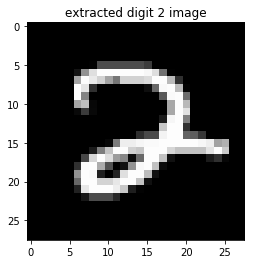

In [19]:
#visualize one of the samples in extracted_two_imgs
data = extracted_two_imgs[1]
plt.imshow(np.reshape(data,(28,28)),cmap='gray')
plt.title("extracted digit 2 image")

It seems that the code picked up images of digit two properly. Now I try to generated the adversary images of those extracted images of digit two to make them misclassified as class of digit six.

In [20]:
def convnet_model_adversary_six(epochs,batch_size,input_imgs,learning_rate):
    #generate new image 
    #retrieve variables 
    with open('./mnist_extract_imgs.p','rb') as f:
        extracted_two_imgs = pickle.load(f)

    #define target class which I want to disguise original image to, and make it onehot code
    class_six = [6]
    onehot_six = np.eye(NUM_CLASSES)[class_six]
    onehot_six_mult = np.zeros((batch_size,NUM_CLASSES))
    for i in range(batch_size):
        onehot_six_mult[i] = onehot_six

    #define another optimizer to update input image
    opt = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropy,var_list=[x_img_var])

    #np array to store generated img
    gen_imgs = input_imgs

    #calculate batch size for testing dataset
    iteration_num = math.ceil(mnist_data.test.labels.shape[0] / batch_size)
    accu_total = 0
    accu_mean = 0

    ### generate adversary images
    with tf.Session() as sess:
         #initialize all variables
        sess.run(tf.global_variables_initializer())

        #restore parameter valuers updated through training
        saver.restore(sess,"./MNIST_weight/model_weight.ckpt")
        print('model is restored')

        #for each image in extracted two, get gradient
        for i in range(epochs): 
            sess.run(assign_x, feed_dict={x_data:np.reshape(gen_imgs,(batch_size,IMAGE_SIZE_1D))})
            opt.run(feed_dict={y_label: onehot_six_mult, keep_prob: 0.5})
            gen_imgs = sess.run(x_img_var)

            if((i+1) % 10 == 0):
                diff = np.reshape(gen_imgs,(batch_size,IMAGE_SIZE_1D)) - np.reshape(extracted_two_imgs,(batch_size,IMAGE_SIZE_1D))
                diff_sum = np.sum(np.sum(diff))
                print ('step%d: %.7f'%((i+1),diff_sum))

        #calcurate the rate of classifying generated images as six
        sess.run(assign_x,feed_dict={x_data:np.reshape(gen_imgs,(batch_size,IMAGE_SIZE_1D))})
        accu = accuracy.eval(feed_dict={y_label: onehot_six_mult, keep_prob: 1.0})
        print ('error rate to classify the images as six is: %.4f' %accu)
    
        #check that to which class the added noise is classified
        n = np.reshape(gen_imgs,(batch_size,IMAGE_SIZE_1D)) - np.reshape(input_imgs,(batch_size,IMAGE_SIZE_1D))
        sess.run(assign_x,feed_dict={x_data:np.reshape(n,(batch_size,IMAGE_SIZE_1D))})
        pred_noise = sess.run(y_conv,feed_dict={keep_prob:1.0})
        pred_noise_list = np.argmax(pred_noise,axis=1).tolist()
        for i in range(batch_size):
            print('prediction of noise%d: %d' %(i,pred_noise_list[i]))
    
        #make sure the model parameters are not updated
        for k in range(iteration_num):
            batch_test = mnist_data.test.next_batch(batch_size)
            sess.run(assign_x,feed_dict={x_data:batch_test[0]})
            accu_total += accuracy.eval(feed_dict={y_label: batch_test[1], keep_prob: 1.0})
        accu_mean = accu_total / iteration_num
        print('average test accuracy %.4f' %accu_mean )

        #reshape the generated imgs 
        np.reshape(n,(batch_size,IMAGE_SIZE_1D))
        np.reshape(gen_imgs,(batch_size,IMAGE_SIZE_1D))

        return n,gen_imgs

In [21]:
#generarte adversary images
added_noise,generated_imgs = convnet_model_adversary_six(epochs_adversary,batch_siz,extracted_two_imgs,learning_rate_adversary)

INFO:tensorflow:Restoring parameters from ./MNIST_weight/model_weight.ckpt
model is restored
step10: 51.1262561
step20: 103.2346807
step30: 147.8394447
step40: 181.1717376
step50: 201.7623108
step60: 215.5658094
step70: 224.8298003
step80: 230.8013602
step90: 235.4270523
step100: 238.5933937
step110: 240.9524481
step120: 242.7524735
step130: 244.1107931
step140: 245.5296788
step150: 246.9520728
error rate to classify the images as six is: 1.0000
prediction of noise0: 5
prediction of noise1: 5
prediction of noise2: 5
prediction of noise3: 7
prediction of noise4: 5
prediction of noise5: 5
prediction of noise6: 9
prediction of noise7: 5
prediction of noise8: 7
prediction of noise9: 5
prediction of noise10: 7
prediction of noise11: 7
prediction of noise12: 7
prediction of noise13: 7
prediction of noise14: 7
prediction of noise15: 7
prediction of noise16: 5
prediction of noise17: 7
prediction of noise18: 5
prediction of noise19: 5
prediction of noise20: 6
prediction of noise21: 7
prediction

Let's visulalize one of the generated adversary images and added noises.

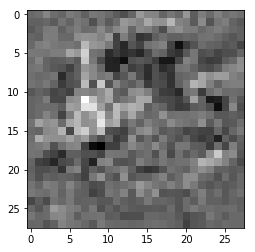

In [22]:
plt.imshow(np.reshape(added_noise[1],(28,28)),cmap='gray')

visualize generated img

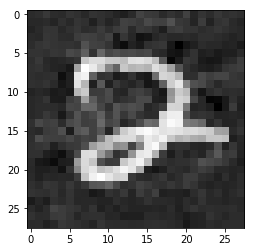

In [23]:
plt.imshow(np.reshape(generated_imgs[1],(28,28)),cmap='gray')

Compare the difference among original images, delta and adversary images

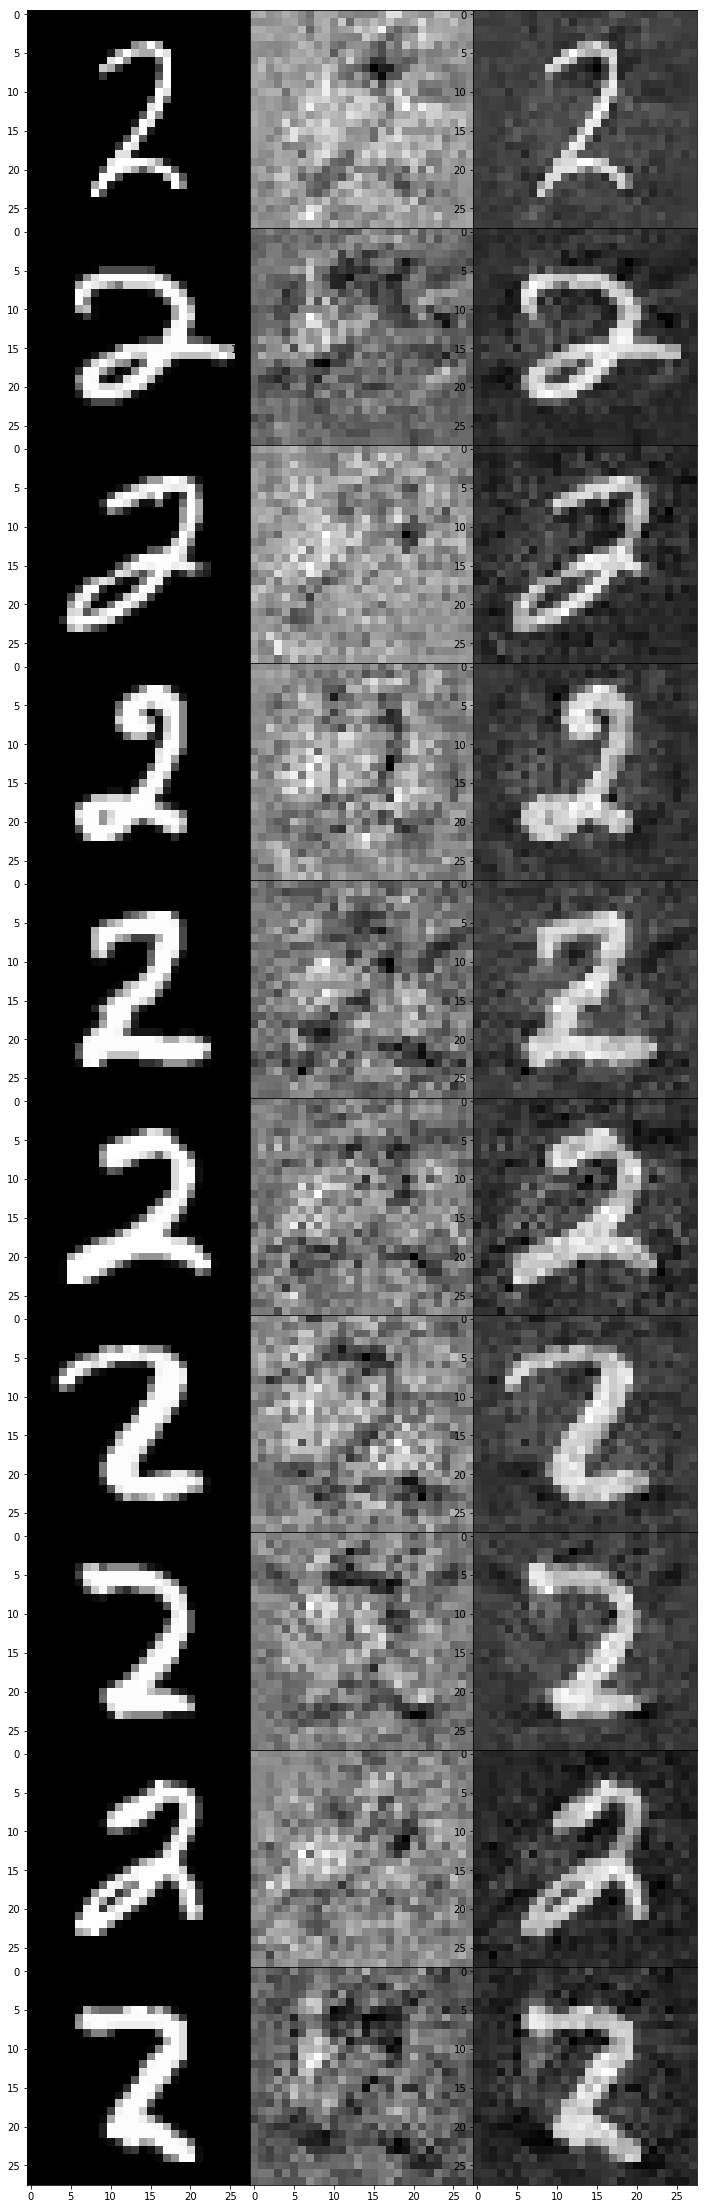

In [24]:
#compare original img, added noise and generated images
fig_conv = plt.figure(figsize=(12,40))
grid = gridspec.GridSpec(10, 3,wspace=0.0,hspace=0.0)

for i in range(10):
    #original images
    ax1 = plt.subplot(grid[i*3])
    ax1.imshow(np.reshape(extracted_two_imgs[i],(28,28)),cmap='gray',interpolation='nearest', aspect='auto')
    fig_conv.add_subplot(ax1)
    
    #delta images
    ax2 = plt.subplot(grid[i*3+1])
    ax2.imshow(np.reshape(added_noise[i],(28,28)),cmap='gray',interpolation='nearest', aspect='auto')
    fig_conv.add_subplot(ax2)
    
    #generated images  
    ax3 = plt.subplot(grid[i*3+2]) 
    ax3.imshow(np.reshape(generated_imgs[i],(28,28)),cmap='gray',interpolation='nearest', aspect='auto')
    fig_conv.add_subplot(ax3)

plt.subplots_adjust(left=None,top=None,bottom=None,right=None,wspace=0,hspace=0)
    
plt.show()
fig_conv.savefig('./MNIST_generated/gen_convnet_model.png',bbox_inches='tight')
fig_conv.clf()

### add perturbation to fool ConvNet model
In this seciton, I try to fool the clssifier by adding perturbation to the original image. It can deceive the model, but I cannot disguise the original images to speciffic target class by using this method.  
To implement this part, I referd to some part of [this repository](https://github.com/jmgilmer/AdversarialMNIST/blob/master/generate_adversarial_examples.ipynb).

In [25]:
#try to fool network by adding perturbation
def convnet_model_fool_perturbation(batch_size,input_imgs,epsilon):
    #generate new image 
    #retrieve variables 
    with open('./mnist_extract_imgs.p','rb') as f:
        extracted_two_imgs = pickle.load(f)

    #define correct class and make it one-hot code
    class_two = [2]
    onehot_two = np.eye(NUM_CLASSES)[class_two]
    class_six = [6]
    onehot_six = np.eye(NUM_CLASSES)[class_six]
    onehot_six_mult = np.zeros((batch_size,NUM_CLASSES))
    onehot_two_mult = np.zeros((batch_size,NUM_CLASSES))
    for i in range(batch_size):
        onehot_six_mult[i] = onehot_six
        onehot_two_mult[i] = onehot_two

    #define another optimizer to update input image
    gradient = tf.gradients(cross_entropy,x_img_var)

    #np array to store generated img
    gen_imgs = np.zeros((batch_size,IMAGE_SIZE_1D))

    #calculate batch size for testing dataset
    iteration_num = math.ceil(mnist_data.test.labels.shape[0] / batch_size)
    accu_total = 0
    accu_mean = 0

    ### generate adversary images
    with tf.Session() as sess:
         #initialize all variables
        sess.run(tf.global_variables_initializer())

        #restore parameter valuers updated through training
        saver.restore(sess,"./MNIST_weight/model_weight.ckpt")
        print('model is restored')

        #the formula for added noise is:
        # n = epcilon * sign(gradient of loss respect to x)
        sess.run(assign_x, feed_dict={x_data:np.reshape(input_imgs,(batch_size,IMAGE_SIZE_1D))})
        gradient_img = sess.run(gradient,feed_dict={y_label: onehot_two_mult, keep_prob: 1.0})
        gen_imgs = np.reshape(input_imgs,(batch_size,IMAGE_SIZE_1D)) + epsilon * np.reshape(np.sign(gradient_img),(batch_size,IMAGE_SIZE_1D))
    
        #check that to which category the added noise and generated images are classified.
        #check added noise
        n = np.reshape(gen_imgs,(batch_size,IMAGE_SIZE_1D)) - np.reshape(input_imgs,(batch_size,IMAGE_SIZE_1D))
        sess.run(assign_x,feed_dict={x_data:np.reshape(n,(batch_size,IMAGE_SIZE_1D))})
        pred_noise = sess.run(y_conv,feed_dict={keep_prob:1.0})
        pred_noise_list = np.argmax(pred_noise,axis=1).tolist()
        
        #check generated images
        sess.run(assign_x,feed_dict={x_data:np.reshape(gen_imgs,(batch_size,IMAGE_SIZE_1D))})
        pred_generated = sess.run(y_conv,feed_dict={keep_prob:1.0})
        pred_generated_list = np.argmax(pred_generated,axis=1).tolist()
        
        #print out the prediction for each samples
        for i in range(batch_size):
            print('prediction of sample%d:noise: %d generated: %d' %(i,pred_noise_list[i],pred_generated_list[i]))
        
        #also check the error rate on classification of adversary images
        sess.run(assign_x,feed_dict={x_data:np.reshape(gen_imgs,(batch_size,IMAGE_SIZE_1D))})
        accu = accuracy.eval(feed_dict={y_label:onehot_two_mult,keep_prob:1.0})
        print('error rate on adversary images: %.4f' %(1-accu) )

        #reshape the generated imgs 
        np.reshape(n,(batch_size,IMAGE_SIZE_1D))
        np.reshape(gen_imgs,(batch_size,IMAGE_SIZE_1D))

        return n,gen_imgs

In [26]:
#fool the network by perturbation
noise_pert,generated_pert = convnet_model_fool_perturbation(batch_siz,extracted_two_imgs,epsilon)

INFO:tensorflow:Restoring parameters from ./MNIST_weight/model_weight.ckpt
model is restored
prediction of sample0:noise: 7 generated: 1
prediction of sample1:noise: 1 generated: 7
prediction of sample2:noise: 5 generated: 3
prediction of sample3:noise: 1 generated: 2
prediction of sample4:noise: 1 generated: 2
prediction of sample5:noise: 7 generated: 7
prediction of sample6:noise: 7 generated: 8
prediction of sample7:noise: 5 generated: 7
prediction of sample8:noise: 5 generated: 8
prediction of sample9:noise: 3 generated: 3
prediction of sample10:noise: 7 generated: 8
prediction of sample11:noise: 5 generated: 4
prediction of sample12:noise: 7 generated: 7
prediction of sample13:noise: 7 generated: 7
prediction of sample14:noise: 3 generated: 2
prediction of sample15:noise: 3 generated: 3
prediction of sample16:noise: 7 generated: 3
prediction of sample17:noise: 5 generated: 8
prediction of sample18:noise: 7 generated: 7
prediction of sample19:noise: 3 generated: 2
prediction of sam